In [3]:
import polars as pl
import os

import sys
sys.path.append('..')
from src import PlottingFunctions

plotter = PlottingFunctions.Plotter()
import numpy as np
import json
from skimage.measure import label

from skimage import measure

from src import IOFunctions; IO = IOFunctions.IO_Functions()

import matplotlib.pyplot as plt

from src import AnalysisFunctions; A_F = AnalysisFunctions.Analysis_Functions()

from src import CoincidenceFunctions; C_F = CoincidenceFunctions.Coincidence_Functions()

In [4]:
cingulate_PD_region = r'S:\ASAP_Imaging_Data\Main_Survey\20241105_oligomers_in_cells\cingulate\neurons\PD_analysis'

In [5]:
def file_selector(folder, oligomer_data, percentile=20):
    files = os.listdir(folder)
    file = np.sort([x for x in files if 'percentile' in x and '_'+str(int(percentile))+'_' in x and '3Danalysis' in x])[0]
    data = pl.read_csv(os.path.join(folder, file))
    photonthreshold = float(file.split('_photonthreshold_')[1].split('_photons_')[0].replace('p', '.'))
    oligomer_data = oligomer_data.filter(pl.col('sum_intensity_in_photons') < 3000)
    percentile = oligomer_data['sum_intensity_in_photons'].rank()/len(oligomer_data['sum_intensity_in_photons'])
    oligomer_data = oligomer_data.with_columns(percentile.alias("alpha"))
    return oligomer_data

In [6]:
cingulate_PD_data = pl.read_csv(os.path.join(cingulate_PD_region, 'spot_analysis.csv'))
cingulate_PD_data = file_selector(cingulate_PD_region, cingulate_PD_data, percentile=90)

In [7]:
filenames = np.unique(cingulate_PD_data['image_filename'].to_numpy())

In [8]:
files = ['20231010_MS_R1_S58_SS1 - Position 1 [9]_XY1697049109_Z00_T5_C1', '20231010_MS_R1_S54_SS2 - Position 1 [9]_XY1697047531_Z00_T6_C1', '20231010_MS_R1_S54_SS3 - Position 1 [9]_XY1697047652_Z00_T7_C1']
filenames = []
for fname in files:
    filenames = np.hstack([filenames, np.unique([x for x in cingulate_PD_data['image_filename'].to_numpy() if fname in x])])

In [9]:
labels = [7, 7, 6]

In [73]:
def quick_plotter(filename, protein_string='C1',
                                       cell_string='C0', xmin=0, 
                                       xmax=1200, ymin=0, ymax=1200, zplane=None, labelval=None):
    raw_protein_image = IO.read_tiff_tophotons(filename)
    analysis_folder = os.path.split(os.path.split(filename)[0])[0]+"_analysis"

    cell_filename = filename.split(protein_string+'.tif')[0]+cell_string+'.tif'
    raw_cell_image = IO.read_tiff_tophotons(cell_filename)
    cell_MIP = np.max(raw_cell_image, axis=0)
    if zplane is not None:
        protein_MIP = raw_protein_image[zplane, : , :]
    else:
        protein_MIP = np.max(raw_protein_image, axis=0)
    cell_mask_string = os.path.split(filename)[-1].split(protein_string+'.tif')[0]+cell_string+'_cellMask_cleanedup.tiff'
    cell_mask = IO.read_tiff(os.path.join(analysis_folder, cell_mask_string))
    labeled_image = label(
        cell_mask, connectivity=3, return_num=False
    )
    mask_toplot = np.max(labeled_image, axis=0)
    if label is not None:
        fig, axs = plotter.one_column_plot()
        mask_toplot = np.max(labeled_image, axis=0)
        mask_toplot[mask_toplot != labelval] = 0
        mask_toplot[mask_toplot == labelval] = 1
        axs[0] = plotter.image_plot(axs=axs[0], data=protein_MIP[xmin:xmax, ymin:ymax],
                                            cbar='off', scalebarsize=200, scalebarlabel='200 nm')      
    
        axs[0].contour(mask_toplot[xmin:xmax, ymin:ymax], [0.5], lw=0.75, colors="white")
        
        plt.tight_layout()
        plt.show(block=False)
    else:
        for value in np.arange(len(np.unique(mask_toplot))):
            fig, axs = plotter.one_column_plot()
            mask_toplot = np.max(labeled_image, axis=0)
            mask_toplot[mask_toplot != value] = 0
            mask_toplot[mask_toplot == value] = 1
            axs[0] = plotter.image_plot(axs=axs[0], data=protein_MIP[xmin:xmax, ymin:ymax],
                                                cbar='off', scalebarsize=200, scalebarlabel='200 nm')      
        
            axs[0].contour(mask_toplot[xmin:xmax, ymin:ymax], [0.5], lw=0.75, colors="white")
            
            plt.tight_layout()
            plt.show(block=False)
    return

20231010_MS_R1_S58_SS1 - Position 1 [9]_XY1697049109_Z00_T5_C1.tif


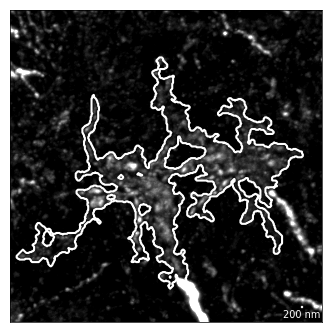

In [74]:
labels = [7, 7, 6]
i = 0
file = filenames[i]
print(os.path.split(file)[-1])
quick_plotter(file, labelval=labels[i], xmin=xmins[i], ymin=ymins[i], width=widths[i])

In [75]:
oligomer_zs = np.array([13, 10, 19])
oligomers_xmins = np.array([165,259,1071])
oligomers_xmaxs = np.array([215,279,1091])
oligomers_ymins = np.array([1015,1062,597])
oligomers_ymaxs = np.array([1065,1082,617])

In [37]:
xmins = np.array([0, 90, 300])
widths = np.array([375, 325, 900])
ymins = np.array([750, 850, 50])

In [35]:
def cell_oligomer_3panel_generator_rawoligomer(filenames, oligomer_data, folder_to_save, protein_string='C1',
                                       cell_string='C0', xmins=0, 
                                       xmaxs=1200, ymins=0, ymaxs=1200, zvals=22):
    mm = 1/25.4
    fig, axs = plotter.two_column_plot(ncolumns=3, widthratio=[1,1,1], height=(170/3)*mm, width=180*mm)

    for i in np.arange(3):
        filename = filenames[i]
        xmin = xmins[i]
        xmax = xmaxs[i]
        ymin = ymins[i]
        ymax = ymaxs[i]
        analysis_folder = os.path.split(os.path.split(filename)[0])[0]+"_analysis"
    
        protein_data = IO.read_tiff_tophotons(filename)[zvals[i], :, :]
        if i == 0:
            scalebarlabel=r'1 $\mu$m'
            scalebarsize=1000
        else:
            scalebarlabel=r'300 nm'
            scalebarsize=300
        axs[i] = plotter.image_plot(axs=axs[i], data=protein_data[xmin:xmax, ymin:ymax],
                                            cbar='off', masklinewidth=0.5, scalebarlabel=scalebarlabel, scalebarsize=scalebarsize)        
    return fig, axs

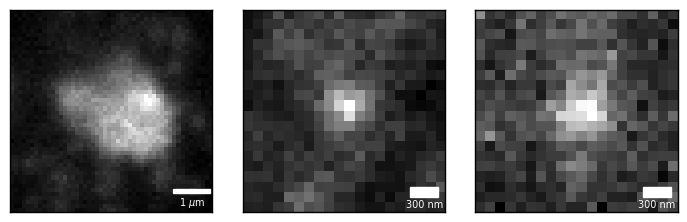

In [38]:
folder_to_save = r'C:\Users\jsb92\Cambridge University Dropbox\Joseph Beckwith'
fig, axs = cell_oligomer_3panel_generator_rawoligomer(filenames, cingulate_PD_data, folder_to_save, xmins=oligomers_xmins, 
                                                      xmaxs=oligomers_xmaxs, ymins=oligomers_ymins, ymaxs=oligomers_ymaxs, zvals=oligomer_zs)
plt.tight_layout()
plt.savefig(os.path.join(folder_to_save, 'Example_oligomersinneurons.svg'), format='svg', dpi=1200)

In [82]:
def cell_oligomer_3panel_generator(filenames, oligomer_data, folder_to_save, protein_string='C1',
                                       cell_string='C0', xmins=0, 
                                       ymins=0, widths=1200, labelvals=0, points=True):
    mm = 1/25.4
    fig, axs = plotter.two_column_plot(ncolumns=3, widthratio=[1,1,1], height=(170/3)*mm, width=180*mm)

    for i in np.arange(3):
        filename = filenames[i]
        xmin = xmins[i]
        ymin = ymins[i]
        width = widths[i]
        labelval = labelvals[i]
        analysis_folder = os.path.split(os.path.split(filename)[0])[0]+"_analysis"
        oligomers = oligomer_data.filter(pl.col('image_filename') == filename)
        oligomers = oligomers.filter(pl.col("alpha") > 0.9)
        x = oligomers['x'].to_numpy()
        y = oligomers['y'].to_numpy()
        alpha = oligomers['alpha'].to_numpy()
        zi = int(np.unique(oligomers['zi'].to_numpy())[0])
        zf = int(np.unique(oligomers['zf'].to_numpy())[0])
    
        cell_filename = filename.split(protein_string+'.tif')[0]+cell_string+'.tif'
        raw_cell_image = IO.read_tiff_tophotons(cell_filename)[zi-1:zf-1, :, :]
        cell_MIP = np.nanmax(raw_cell_image, axis=0)
        cell_mask_string = os.path.split(filename)[-1].split(protein_string+'.tif')[0]+cell_string+'_cellMask_cleanedup.tiff'
        cell_mask = IO.read_tiff(os.path.join(analysis_folder, cell_mask_string))
        labeled_image = label(
        cell_mask, connectivity=3, return_num=False
        )
        mask_toplot = np.max(labeled_image, axis=0)
        mask_toplot[mask_toplot != labelval] = 0
        mask_toplot[mask_toplot == labelval] = 1
        
        punctaindices = (x > xmin) & (x < xmin+width) & (y > ymin) & (y < ymin+width)
        x = x[punctaindices] 
        y = y[punctaindices]
        alpha = alpha[punctaindices]
        centroids = np.vstack([np.array(x, dtype=int), np.array(y, dtype=int)]).T
        mask_indices = A_F.generate_indices(np.array(mask_toplot, dtype=bool), (1200, 1200), is_mask=True)
        spot_indices = A_F.generate_indices(centroids, (1200, 1200))
        spot_indices = C_F._apply_blur(spot_indices, (1200, 1200), 1)
    
        in_cell = C_F.test_spot_spot_overlap(spot_indices, mask_indices, n_spot1=len(x), raw=True)
        x = x[in_cell == True]
        y = y[in_cell == True]
        alpha = alpha[in_cell == True]
        
        colours = np.array(np.full(len(x), 'red'), dtype='str')
        
        savestring =  os.path.split(filename)[-1].split(protein_string+'.tif')[0]+cell_string+'_examplemicroglia_witholigs.svg'
        if points == True:
            if i == 0:
                axs[i] = plotter.image_scatter_plot(axs=axs[i], data=cell_MIP[xmin:xmin+width, ymin:ymin+width], xdata=x-xmin, ydata=y-ymin, facecolor=colours, 
                                                    alpha_scatter=alpha, s=2, lws=0, plotmask=True, mask=mask_toplot[xmin:xmin+width, ymin:ymin+width], cbar='off',
                                                    masklinewidth=0.75, maskcolor='#7990c3', scalebarlabel=r'10 $\mu$m', scalebarsize=10000,
                                                   vmin=300, vmax=1200)
            else:
                axs[i] = plotter.image_scatter_plot(axs=axs[i], data=cell_MIP[xmin:xmin+width, ymin:ymin+width], xdata=x-xmin, ydata=y-ymin, facecolor=colours, 
                                    alpha_scatter=alpha, s=2, lws=0, plotmask=True, mask=mask_toplot[xmin:xmin+width, ymin:ymin+width], cbar='off',
                                    masklinewidth=0.75, maskcolor='#7990c3', scalebarlabel=r'10 $\mu$m', scalebarsize=10000)
        else:
            axs[i] = plotter.image_plot(axs=axs[i], data=cell_MIP[xmin:xmin+width, ymin:ymin+width],
                                                plotmask=True, mask=mask_toplot[xmin:xmin+width, ymin:ymin+width], cbar='off', masklinewidth=0.5)        
    return fig, axs

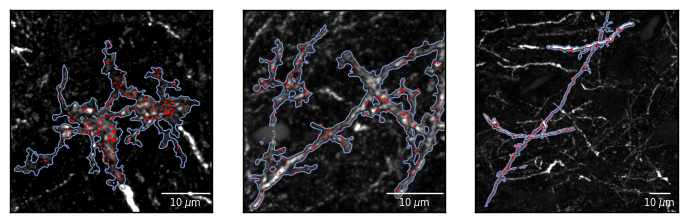

In [83]:
folder_to_save = r'C:\Users\jsb92\Cambridge University Dropbox\Joseph Beckwith'
fig, axs = cell_oligomer_3panel_generator(filenames, cingulate_PD_data, folder_to_save, xmins=xmins, ymins=ymins, widths=widths, labelvals=labels)
plt.tight_layout()
plt.savefig(os.path.join(folder_to_save, 'Example_neuronfigure.svg'), format='svg', dpi=1200)